<a href="https://colab.research.google.com/github/FionaSpace/QRL_TicTacToe/blob/main/%E2%80%9CRun%20and%20Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import time 
import copy
import gym
from gym import spaces
import pandas as pd
CODE_MARK_MAP = {0: ' ', 1: '0', 2: 'X'}
NUM_LOC = 9
O_REWARD = 2000
X_REWARD = -2000
NO_REWARD = 0

LEFT_PAD = '  '
LOG_FMT = logging.Formatter('%(levelname)s '
                            '[%(filename)s:%(lineno)d] %(message)s',
                            '%Y-%m-%d %H:%M:%S')


def tomark(code):
    return CODE_MARK_MAP[code]


def tocode(mark):
    return 1 if mark == 'O' else 2


def next_mark(mark):
    return 'X' if mark == 'O' else 'O'


def agent_by_mark(agents, mark):
    for agent in agents:
        if agent.mark == mark:
            return agent


def after_action_state(state, action):
    """Execute an action and returns resulted state.
    Args:
        state (tuple): Board status + mark
        action (int): Action to run
    Returns:
        tuple: New state
    """
    print(state)
    board = state[:9]
    mark=tomark(state[-1])
    nboard = list(board[:])
    nboard[action] = tocode(mark)
    nboard = tuple(nboard)
  #  return nboard, next_mark(mark)
    b=tocode(next_mark(mark))
    a=list(nboard)+[b]
    return a

def check_game_status(board):
    """Return game status by current board status.
    Args:
        board (list): Current board state
    Returns:
        int:
            -1: game in progress
            0: draw game,
            1 or 2 for finished game(winner mark code).
    """
    for t in [1, 2]:
        for j in range(0, 9, 3):
            if [t] * 3 == [board[i] for i in range(j, j+3)]:
                return t
        for j in range(0, 3):
            if board[j] == t and board[j+3] == t and board[j+6] == t:
                return t
        if board[0] == t and board[4] == t and board[8] == t:
            return t
        if board[2] == t and board[4] == t and board[6] == t:
            return t

    for i in range(9):
        if board[i] == 0:
            # still playing
            return -1

    # draw game
    return 0


class TicTacToeEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, alpha=0.02, show_number=False):
        self.action_space = spaces.Discrete(NUM_LOC)
        self.observation_space = spaces.Discrete(NUM_LOC)
        self.alpha = alpha
        self.set_start_mark('O')
        self.show_number = show_number
        self.seed()
        self.reset()

    def set_start_mark(self, mark):
        self.start_mark = mark

    def reset(self):
        self.board = [0] * NUM_LOC
        self.mark = self.start_mark
        self.done = False
        return self._get_obs()

    def step(self, action):
        """Step environment by action.
        Args:
            action (int): Location
        Returns:
            list: Obeservation
            int: Reward
            bool: Done
            dict: Additional information
        """
        assert self.action_space.contains(action)

        loc = action
        if self.done:
            return self._get_obs(), 0, True, None

        reward = NO_REWARD
        # place
        self.board[loc] = tocode(self.mark)
        status = check_game_status(self.board)
        #print(status)
        #logging.debug("check_game_status board {} mark '{}'"
         #             " status {}".format(self.board, self.mark, status))
        if status >= 0:
            self.done = True
            if status==1:
                # always called by self
                reward = 2000
            if status==2:
                reward = -2000

        # switch turn
        self.mark = next_mark(self.mark)
        #print(reward)
        return self._get_obs(), reward, self.done, None

    def _get_obs(self):
       # return tuple(self.board), self.mark
      c=self.board+[tocode(self.mark)]
      return c

    def render(self, mode='human', close=False):
        if close:
            return
        if mode == 'human':
            self._show_board(print)  # NOQA
            print('')
        else:
            self._show_board(logging.info)
            logging.info('')

    def show_episode(self, human, episode):
        self._show_episode(print if human else logging.warning, episode)

    def _show_episode(self, showfn, episode):
        showfn("==== Episode {} ====".format(episode))

    def _show_board(self, showfn):
        """Draw tictactoe board."""
        for j in range(0, 9, 3):
            def mark(i):
                return tomark(self.board[i]) if not self.show_number or\
                    self.board[i] != 0 else str(i+1)
            showfn(LEFT_PAD + '|'.join([mark(i) for i in range(j, j+3)]))
            if j < 6:
                showfn(LEFT_PAD + '-----')

    def show_turn(self, human, mark):
        self._show_turn(print if human else logging.info, mark)

    def _show_turn(self, showfn, mark):
        showfn("{}'s turn.".format(mark))

    def show_result(self, human, mark, reward):
        self._show_result(print if human else logging.info, mark, reward)

    def _show_result(self, showfn, mark, reward):
        status = check_game_status(self.board)
        if status >= 0:
         if status == 0:
            showfn("==== Finished: Draw ====")
         else:
            msg = "Winner is '{}'!".format(tomark(status))
            showfn("==== Finished: {} ====".format(msg))
        showfn('')
       
    def available_actions(self):
        return [i for i, c in enumerate(self.board) if c == 0]


def set_log_level_by(verbosity):
    """Set log level by verbosity level.
    verbosity vs log level:
        0 -> logging.ERROR
        1 -> logging.WARNING
        2 -> logging.INFO
        3 -> logging.DEBUG
    Args:
        verbosity (int): Verbosity level given by CLI option.
    Returns:
        (int): Matching log level.
    """
    if verbosity == 0:
        level = 40
    elif verbosity == 1:
        level = 30
    elif verbosity == 2:
        level = 20
    elif verbosity >= 3:
        level = 10

    logger = logging.getLogger()
    logger.setLevel(level)
    if len(logger.handlers):
        handler = logger.handlers[0]
    else:
        handler = logging.StreamHandler()
        logger.addHandler(handler)

    handler.setLevel(level)
    handler.setFormatter(LOG_FMT)
    return level


In [ ]:
!pip install tensorflow==2.7.0

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Foun

In [ ]:
!pip install tensorflow-quantum==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
!pip install gym==0.18.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import importlib, pkg_resources
importlib.reload(pkg_resources)
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/lo

In [ ]:

import random

class Teacher:
    """ 
    A class to implement a teacher that knows the optimal playing strategy.
    Teacher returns the best move at any time given the current state of the game.
    Note: things are a bit more hard-coded here, as this was not the main focus of
    the exercise so I did not spend as much time on design/style. Everything works
    properly when tested.
    Parameters
    ----------
    level : float 
        teacher ability level. This is a value between 0-1 that indicates the
        probability of making the optimal move at any given time.
    """

    def __init__(self, level=0.9):
        """
        Ability level determines the probability that the teacher will follow
        the optimal strategy as opposed to choosing a random available move.
        """
        self.ability_level = level

    def win(self, board, key=2):
        """ If we have two in a row and the 3rd is available, take it. """
        # Check for diagonal wins
        a = [board[0], board[4], board[8]]
        b = [board[2], board[4], board[6]]
        if a.count(0) == 1 and a.count(key) == 2:
            ind = a.index(0)
            if ind == 0:
                return 0
            elif ind == 1:
                return 4
            else:
                return 8
        elif b.count(0) == 1 and b.count(key) == 2:
            ind = b.index(0)
            if ind == 0:
                return 2
            elif ind == 1:
                return 4
            else:
                return 6
        # Now check for 2 in a row/column + empty 3rd
        for i in range(3):
            c = [board[i], board[3+i], board[6+i]]
            d = [board[i*3], board[i*3+1], board[i*3+2]]
            if c.count(0) == 1 and c.count(key) == 2:
                ind = c.index(0)
                return ind*3+i
            elif d.count(0) == 1 and d.count(key) == 2:
                ind = d.index(0)
                return i*3+ind
        return None

    def blockWin(self, board):
        """ Block the opponent if she has a win available. """
        return self.win(board, key=1)

    def fork(self, board):
        """ Create a fork opportunity such that we have 2 threats to win. """
        # Check all adjacent side middles
        if board[3] == 2 and board[1] == 2:
            if board[0] == 0 and board[6] == 0 and board[2] == 0:
                return 0
            elif board[4] == 0 and board[7] ==0  and board[5] == 0:
                return 4
        elif board[3] == 2 and board[7] == 2:
            if board[6] == 0 and board[0] == 0 and board[8] == 0:
                return 6
            elif board[4] == 0 and board[1] == 0 and board[5] == 0:
                return 4
        elif board[7] == 2 and board[5] == 2:
            if board[8] == 0 and board[6] == 0 and board[2] ==0:
                return 8
            elif board[4] == 0 and board[3] == 0 and board[1] == 0:
                return 4
        elif board[5] == 2 and board[1] == 2:
            if board[2] == 0 and board[0] == 0 and board[8] == 0:
                return 2
            elif board[4] == 0 and board[3] == 0 and board[7] == 0:
                return 4
        # Check all cross corners
        elif board[0] == 2 and board[8] == 2:
            if board[3] == 0 and board[7] == 0 and board[6] == 0:
                return 6
            elif board[1] == 0 and board[5] == 0 and board[2] == 0:
                return 2
        elif board[6] == 2 and board[2] == 2:
            if board[7] == 0 and board[5] == 0 and board[8] == 0:
                return 8
            elif board[3] == 0 and board[1] == 0 and board[0] == 0:
                return 0
        return None

    def blockFork(self, board):
        """ Block the opponents fork if she has one available. """
        corners = [board[0], board[6], board[2], board[8]]
        # Check all adjacent side middles
        if board[3] == 1 and board[1] == 1:
            if board[0] == 0 and board[6] == 0 and board[2] == 0:
                return 0
            elif board[4] == 0 and board[7] == 0 and board[5] == 0:
                return 4
        elif board[3] == 1 and board[7] == 1:
            if board[6] == 0 and board[0] == 0 and board[8] == 0:
                return 6
            elif board[4] == 0 and board[1] == 0 and board[5] == 0:
                return 4
        elif board[7] == 1 and board[5] == 1:
            if board[8] == 0 and board[6] == 0 and board[2] == 0:
                return 8
            elif board[4] == 0 and board[3] == 0 and board[1] == 0:
                return 4
        elif board[5] == 1 and board[1] == 1:
            if board[2] == 0 and board[0] == 0 and board[8] == 0:
                return 2
            elif board[4] == 0 and board[3] == 0 and board[7] == 0:
                return 4
        # Check all cross corners (first check for double fork opp using the corners array)
        elif corners.count(0) == 1 and corners.count(1) == 2:
            return 5
        elif board[0] == 1 and board[8] == 1:
            if board[3] == 0 and board[7] == 0 and board[6] == 0:
                return 6
            elif board[1] == 0 and board[5] == 0 and board[2] == 0:
                return 2
        elif board[6] == 1 and board[2] == 1:
            if board[7] == 0 and board[5] == 0 and board[8] == 0:
                return 8
            elif board[3] == 0 and board[1] == 0 and board[0] == 0:
                return 0
        return None

    def center(self, board):
        """ Pick the center if it is available. """
        if board[4] == 0:
            return 4
        return None

    def corner(self, board):
        """ Pick a corner move. """
        # Pick opposite corner of opponent if available
        if board[0] == 1 and board[8] == 0:
            return 8
        elif board[6] == 1 and board[2] == 0:
            return 2
        elif board[2] == 1 and board[6] == 0:
            return 6
        elif board[8] == 1 and board[0] == 0:
            return 0
        # Pick any corner if no opposites are available
        elif board[0] == 0:
            return 0
        elif board[6] == 0:
            return 6
        elif board[2] == 0:
            return 2
        elif board[8] == 0:
            return 8
        return None

    def sideEmpty(self, board):
        """ Pick an empty side. """
        if board[3] == 0:
            return 3
        elif board[7] == 0:
            return 7
        elif board[5] == 0:
            return 5
        elif board[1] == 0:
            return 1
        return None

    def randomMove(self, board):
        """ Chose a random move from the available options. """
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i*3+j] == 0:
                    possibles += [(i*3+j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        """
        Trainer goes through a hierarchy of moves, making the best move that
        is currently available each time. A touple is returned that represents
        (row, col).
        """
        # Chose randomly with some probability so that the teacher does not always win
        if random.random() > self.ability_level:
            return self.randomMove(board)
        # Follow optimal strategy
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [ ]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)
    
    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))
    
    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
    
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))
    
    return circuit, list(params.flat), list(inputs.flat)

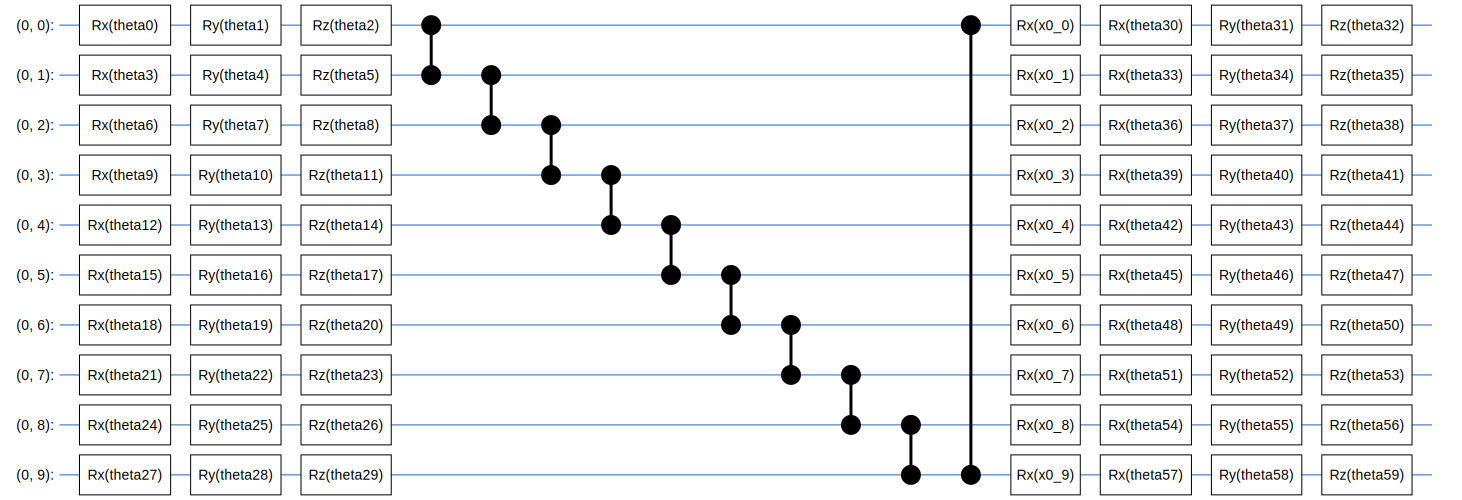

In [ ]:
n_qubits, n_layers = 10, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

In [ ]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )
        
        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )
        
        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])
        
        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        
        return self.computation_layer([tiled_up_circuits, joined_vars])

In [ ]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [ ]:
n_qubits = 10 # Dimension of the state vectors in Tic-Tac-Toe
n_layers = 5 # Number of layers in the PQC
n_actions = 9 # Number of actions in Tic-Tac-Toe

qubits = cirq.GridQubit.rect(1, n_qubits)

In [ ]:
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

In [ ]:
def generate_model_policy(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC policy."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        #tf.keras.layers.Softmax()
    ], name="observables-policy")
    #policy = process(re_uploading_pqc)
    ob=process(re_uploading_pqc)
    print(ob)
    #model = tf.keras.Model(inputs=[input_tensor], outputs=policy)
    model = tf.keras.Model(inputs=[input_tensor], outputs=ob)
    
    return model

model = generate_model_policy(qubits, n_layers, n_actions, 1.0, observables)

KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), name='observables-policy/lambda/mul:0', description="created by layer 'observables-policy'")


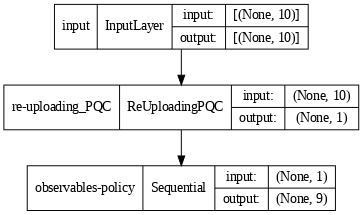

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
class BaseAgent(object):
    def __init__(self, mark):
        self.mark = mark

    def act(self, state, ava_actions):
        for action in ava_actions:
            nstate = after_action_state(state, action)
            gstatus = check_game_status(nstate[0])
            if gstatus > 0:
                if tomark(gstatus) == self.mark:
                    return action
        return random.choice(ava_actions)
def gather_episodes(n_actions, model, n_episodes,batch):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [TicTacToeEnv() for _ in range(n_episodes)]
    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]
    board=[1 for e in envs]
    #print(states)
    marks=[1 for _ in range(n_episodes)]
    agent=[1 for _ in range(n_episodes)]
    ava_actions=[[1] for _ in range(n_episodes)]
    step=0
    wins = [1 for _ in range(n_episodes)]
    start_mark = 'O'
    agents = [BaseAgent('O'),
              BaseAgent('X')]
    while not all(done):
        step+=1
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s for i, s in enumerate(states) if not done[i]]
       # print(normalized_states)
        if start_mark=='X':
         for i, state in zip(unfinished_ids, normalized_states):
             ava_actions[i] = envs[i].available_actions()
             board[i]=state[0:9]
             action = Teacher().makeMove(board[i])
             states[i],reward, done[i], info = envs[i].step(action)
             wins[i] = check_game_status(states[i][:9])
             if wins[i]==2:
               wins[i]=-1
        else:
         for i, state in zip(unfinished_ids, normalized_states):
             trajectories[i]['states'].append(state)
             ava_actions[i] = envs[i].available_actions()
         states = tf.convert_to_tensor(normalized_states)
         action_probs = model([states])
         states = [None for i in range(n_episodes)]
         for i, policy in zip(unfinished_ids, action_probs.numpy()):
             for j in range(9):
                if j not in ava_actions[i]:
                   policy[j]=-1000000
             s=np.sum(np.exp(policy))
             policy=np.exp(policy)/s
             policy=policy.tolist()
             action= policy.index(max(policy))
             states[i],reward, done[i], info = envs[i].step(action)
             wins[i] = check_game_status(states[i][:9])
             if wins[i]==2:
               wins[i]=-1
             trajectories[i]['actions'].append(action)
             trajectories[i]['rewards'].append(reward)
        start_mark = next_mark(start_mark)
    return trajectories,wins

In [ ]:
def compute_returns(rewards_history,win):
    """Compute discounted returns with discount factor `gamma`."""
    #returns = []
    #discounted_sum = 0
    #for r in rewards_history[::-1]:
     #   discounted_sum += r 
    #    returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    #returns = np.array(returns)
    #returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    #returns = returns.tolist()
    
   # return rewards_history
   
    returns = []
    if win==-1:
      discounted_sum=-2000
    else:
      discounted_sum = 0
    for r in rewards_history[::-1]:
      discounted_sum = r + 0.2 * discounted_sum
      returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()
    
    return returns

In [ ]:
#state_bounds = np.array([0.6, 0.07])
gamma = 1
batch_size = 60
n_episodes = 6000000

In [ ]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [ ]:
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])


In [ ]:


# Start training the agent
r=0
for batch in range(n_episodes // batch_size):
    episode_reward_history = []# Gather episodes
    episodes,wins = gather_episodes(n_actions, model, batch_size,batch)
    
    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    #print(rewards)
    returns = np.concatenate([compute_returns(rewards[i],wins[i]) for i in range(60)])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])
    
    # Update model parameters.
    
    # Store collected rewards
    for i in range(60):
      if wins[i]==-1:
        r=np.sum(rewards[i])-2000
      else:
        r=np.sum(rewards[i])
      episode_reward_history.append(r)
    #print(episode_reward_history)
       #episode_reward_history=np.sum(ep_rwds)
    avg_rewards = np.mean(episode_reward_history)
    #print(wins)
    wi=wins.count(1)
    dr=wins.count(0)
    lo=wins.count(-1)
    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards,
          'wins number:',wi,
          'draw number:',dr,
          'lose number:',lo)
    if avg_rewards>120:
        break
    reinforce_update(states, id_action_pairs, returns, model)
    

/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Finished episode 60 Average rewards:  -1400.0 wins number: 9 draw number: 0 lose number: 51
Finished episode 120 Average rewards:  -1733.3333333333333 wins number: 3 draw number: 2 lose number: 55
Finished episode 180 Average rewards:  66.66666666666667 wins number: 7 draw number: 48 lose number: 5
Finished episode 240 Average rewards:  66.66666666666667 wins number: 9 draw number: 44 lose number: 7
Finished episode 300 Average rewards:  -2000.0 wins number: 0 draw number: 0 lose number: 60
Finished episode 360 Average rewards:  -1733.3333333333333 wins number: 4 draw number: 0 lose number: 56
Finished episode 420 Average rewards:  -1633.3333333333333 wins number: 2 draw number: 7 lose number: 51
Finished episode 480 Average rewards:  -1700.0 wins number: 3 draw number: 3 lose number: 54
Finished episode 540 Average rewards:  -1500.0 wins number: 3 draw number: 9 lose number: 48
Finished episode 600 Average rewards:  -1400.0 wins number: 5 draw number: 8 lose number: 47
Finished episod

In [ ]:
win_list=[]
for i in range(100):
    episode_reward_history = []# Gather episodes
    envs = TicTacToeEnv()
    n_actions=10
    done = False
    states = envs.reset()
    #print(states)
    marks=1
    agent=1
    ava_actions=[1]
    step=0
    wins = 1
    start_mark = 'O'
    agents = [BaseAgent('O'),
              BaseAgent('X')]
    while not done:
        step+=1
        envs.show_turn(True, start_mark)
        agent = agent_by_mark(agents, start_mark)
        if start_mark=='X':
             board=states[0:9]
             action = Teacher().makeMove(board)
             states,reward, done, info = envs.step(action)
             envs.render()
             wins = check_game_status(states[:9])
             if wins==2:
               wins=-1
        else:
             ava_actions= envs.available_actions()
             #print(states)
             states = tf.convert_to_tensor([states])
             #print(states)
             prob = model([states]).numpy()
             policy=prob[0]
             states = None
            # print(policy)
             for j in range(9):
                if j not in ava_actions:
                   policy[j]=-100000
             s=np.sum(np.exp(policy))
             policy=np.exp(policy)/s
             policy=policy.tolist()
             action= policy.index(max(policy))
             states,reward, done, info = envs.step(action)
             envs.render()
             wins = check_game_status(states[:9])
             if wins==2: 
                wins=-1
        start_mark = next_mark(start_mark)
    #start_mark = next_mark(start_mark)
    envs.show_result(True, '0', reward)
    win_list.append(wins)
w=win_list.count(1)
l=win_list.count(-1)
d=win_list.count(0)
print('wins:',w,"lose:",l,"draw:",d)
    

流式输出内容被截断，只能显示最后 5000 行内容。
  -----
  X|X|0
  -----
  0|0|X

==== Finished: Draw ====

O's turn.
  0| | 
  -----
   | | 
  -----
   | | 

X's turn.
  0| | 
  -----
   |X| 
  -----
   | | 

O's turn.
  0|0| 
  -----
   |X| 
  -----
   | | 

X's turn.
  0|0|X
  -----
   |X| 
  -----
   | | 

O's turn.
  0|0|X
  -----
   |X| 
  -----
  0| | 

X's turn.
  0|0|X
  -----
  X|X| 
  -----
  0| | 

O's turn.
  0|0|X
  -----
  X|X|0
  -----
  0| | 

X's turn.
  0|0|X
  -----
  X|X|0
  -----
  0|X| 

O's turn.
  0|0|X
  -----
  X|X|0
  -----
  0|X|0

==== Finished: Draw ====

O's turn.
  0| | 
  -----
   | | 
  -----
   | | 

X's turn.
  0| | 
  -----
   |X| 
  -----
   | | 

O's turn.
  0|0| 
  -----
   |X| 
  -----
   | | 

X's turn.
  0|0|X
  -----
   |X| 
  -----
   | | 

O's turn.
  0|0|X
  -----
   |X| 
  -----
  0| | 

X's turn.
  0|0|X
  -----
  X|X| 
  -----
  0| | 

O's turn.
  0|0|X
  -----
  X|X|0
  -----
  0| | 

X's turn.
  0|0|X
  -----
  X|X|0
  -----
  0| |X

O's turn.
  0|0|X
  -